# Modeling with Pyomo

This page is [adapted from our process control class](https://github.com/ndcbe/controls/blob/main/notebooks/06.02-Simulation-and-Open-Loop-Optimal-Control.ipynb) at Notre Dame; it was developed by Prof. Jeff Kantor.

In [1]:
# Install Pyomo and solvers for Google Colab
import sys

if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/IDAES/idaes-pse/main/scripts/colab_helper.py"
    import colab_helper

    colab_helper.install_idaes()
    colab_helper.install_ipopt()

# Set plotting defaults
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=3)

In this notebook, we will review Pyomo syntax solving optimization problems with our [TCLab model](./tclab_model.ipynb).

Let's start by defining some model coefficients:

In [2]:
# parameters
alpha = 0.00016  # watts / (units P * percent U1)
P = 200  # P units
Ua = 0.050  # heat transfer coefficient from heater to environment
CpH = 2.2  # heat capacity of the heater (J/deg C)
CpS = 1.9  # heat capacity of the sensor (J/deg C)
Ub = 0.021  # heat transfer coefficient from heater to sensor
Tamb = 21.0  # ambient temperature

## Simulate a Step Test (ramp)

We will start by **simulating** our TCLab model. In other words, we will solve the following optimization problem with zero degrees of freedom:

\begin{align*}
\max{}~~ & 0 \\
\mathrm{s.t.}~~ & C_p^H \frac{dT_H}{dt} = U_a (T_{amb} - T_H) + U_b (T_S - T_H) + \alpha P u(t) \\
 & C_p^S \frac{dT_S}{dt} = - U_b (T_S - T_H) \\
 & T_H(t_0) = T_{amb} \\
 & T_S(t_0) = T_{amb} \\
 & u(t) = u_{ramp} = 50\%, \quad \forall t \in [t_0, t_f]
\end{align*}

Here "s.t." means "subject to", i.e., the constraints.

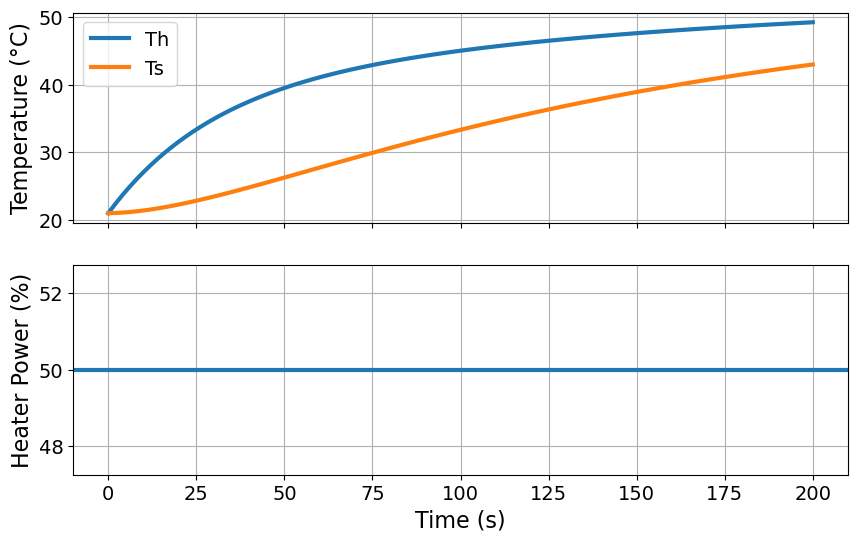

In [3]:
# final time [seconds]
tf = 200

# control input [%]
u = 50.0

# import Pyomo library
import pyomo.environ as pyo
import pyomo.dae as dae

# Create a Pyomo model
m = pyo.ConcreteModel('TCLab Heater/Sensor')

# Define time domain
m.t = dae.ContinuousSet(bounds=(0, tf))

# Define the state variables as a function of time
m.Th = pyo.Var(m.t)
m.Ts = pyo.Var(m.t)

# Define the derivatives of the state variables
m.dTh = dae.DerivativeVar(m.Th)
m.dTs = dae.DerivativeVar(m.Ts)


# Define the first differential equation
def heater1(m, t):
    return (
        CpH * m.dTh[t]
        == Ua * (Tamb - m.Th[t]) + Ub * (m.Ts[t] - m.Th[t]) + alpha * P * u
    )


m.heater1_con = pyo.Constraint(m.t, rule=heater1)


# Define the second differential equation
def sensor1(m, t):
    return CpS * m.dTs[t] == Ub * (m.Th[t] - m.Ts[t])


m.sensor1_con = pyo.Constraint(m.t, rule=sensor1)

# Set the initial conditions
m.Th[0].fix(Tamb)
m.Ts[0].fix(Tamb)

# Apply a finite difference formula to numerically integrate the differential equations
pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, wrt=m.t)

# Call our nonlinear optimization/equation solver, Ipopt
pyo.SolverFactory('ipopt').solve(m)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot 1: Temperature
ax[0].plot(m.t, [m.Th[t]() for t in m.t], label="Th")
ax[0].plot(m.t, [m.Ts[t]() for t in m.t], label="Ts")
ax[0].legend()
ax[0].set_ylabel("Temperature (°C)")
ax[0].grid()

# Plot 2: Heater Power
ax[1].axhline(u, label="Power")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Heater Power (%)")
ax[1].grid()

The code below to access and print results from the Pyomo model:


In [4]:
for i, t in enumerate(m.t):
    # Only print every 10 timesteps
    if i % 10 == 0:
        print(
            "Th=",
            round(pyo.value(m.Th[t]), 2),
            "°C and Ts=",
            round(pyo.value(m.Ts[t]), 2),
            "°C at time",
            round(t, 2),
            "seconds.",
        )

Th= 21.0 °C and Ts= 21.0 °C at time 0 seconds.
Th= 31.56 °C and Ts= 22.28 °C at time 20.0 seconds.
Th= 37.51 °C and Ts= 24.82 °C at time 40.0 seconds.
Th= 41.08 °C and Ts= 27.73 °C at time 60.0 seconds.
Th= 43.39 °C and Ts= 30.63 °C at time 80.0 seconds.
Th= 45.01 °C and Ts= 33.32 °C at time 100.0 seconds.
Th= 46.22 °C and Ts= 35.76 °C at time 120.0 seconds.
Th= 47.18 °C and Ts= 37.92 °C at time 140.0 seconds.
Th= 47.97 °C and Ts= 39.83 °C at time 160.0 seconds.
Th= 48.64 °C and Ts= 41.51 °C at time 180.0 seconds.
Th= 49.21 °C and Ts= 42.97 °C at time 200 seconds.


Uncomment and run the code below to see the details of the Pyomo model:

In [5]:
# m.pprint()

## Activity: Optimization by Trial-and-Error

Modify the code above to find the value for `u` that causes `Th` to reach 60 °C at the final time. In others words, we are using trial and error to solve the following optimization problem:

\begin{align*}
\min_{u_{ramp}} ~~ & ||~ T_{H}(t_f) - 60 ~||^2 \\
\mathrm{s.t.}~~ & C_p^H \frac{dT_H}{dt} = U_a (T_{amb} - T_H) + U_b (T_S - T_H) + \alpha P u(t) \\
 & C_p^S \frac{dT_S}{dt} = - U_b (T_S - T_H) \\
 & T_H(t_0) = T_{amb} \\
 & T_S(t_0) = T_{amb} \\
 & u(t) = u_{ramp}, \quad \forall t \in [t_0, t_f]
\end{align*}


## Feedforward Optimal Control

An optimal control policy minimizes the differences

$$
\begin{align*}
\min_{u} \int_{t_0}^{t_f} \|~SP(t) - T_H(t)~\|^2\,dt \\
\end{align*}
$$

subject to constraints

$$
\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_c (T_S - T_H) + \alpha P u(t)\\
C_p^S \frac{dT_S}{dt} & = - U_b (T_S - T_H)  \\
\\
\text{control limits}\qquad0 \leq u(t) & \leq 100.0
\\
\text{initial condition}\qquad T_H(t_0) & = T_{amb} \\
\text{initial condition}\qquad T_S(t_0) & = T_{amb}
\end{align*}
$$

This is different than our example above because we allow $u$ to have a unique value for each timestep.

Note that `pyomo.dae` has an `Integral` object to help with these situations.

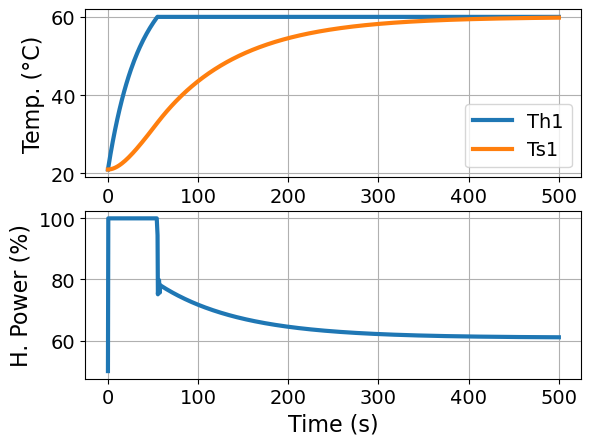

In [6]:
# Set point, deg C
SP = 60.0

# Final time, seconds
tf = 500.0

# Create a Pyomo model
m = pyo.ConcreteModel('TCLab Heater/Sensor')

# Define time domain
m.t = dae.ContinuousSet(bounds=(0, tf))

# Define the state variables as a function of time
m.Th1 = pyo.Var(m.t)
m.Ts1 = pyo.Var(m.t)

# Define the derivatives of the state variables
m.dTh1 = dae.DerivativeVar(m.Th1)
m.dTs1 = dae.DerivativeVar(m.Ts1)

# Define the control variable (heater power) as a function of time
m.u1 = pyo.Var(m.t, bounds=(0, 100))


# Define the integral of the squared error
@m.Integral(m.t)
def ise(m, t):
    return (SP - m.Th1[t]) ** 2


# Define the first differential equation
# Notice we are defining the equation using the decorator syntax
@m.Constraint(m.t)
def heater1(m, t):
    return (
        CpH * m.dTh1[t]
        == Ua * (Tamb - m.Th1[t]) + Ub * (m.Ts1[t] - m.Th1[t]) + alpha * P * m.u1[t]
    )


# Define the second differential equation
@m.Constraint(m.t)
def sensor1(m, t):
    return CpS * m.dTs1[t] == Ub * (m.Th1[t] - m.Ts1[t])


# Set the initial conditions
m.Th1[0].fix(Tamb)
m.Ts1[0].fix(Tamb)


# Define the objective function
@m.Objective(sense=pyo.minimize)
def objective(m):
    return m.ise


# Apply a collocation method to numerically integrate the differential equations
pyo.TransformationFactory('dae.collocation').apply_to(m, nfe=200, wrt=m.t)

# Call our nonlinear optimization/equation solver, Ipopt
pyo.SolverFactory('ipopt').solve(m)

# We are going to repeat plotting two more times,
# so let's define a function
def plot_results(m):
    """
    Plot results from Pyomo optimization

    Arguments:
    m: Pyomo model

    Returns:
    Nothing
    
    """

    # Plot the results
    fig, ax = plt.subplots(2, 1)

    ax[0].plot(m.t, [m.Th1[t]() for t in m.t], label="Th1")
    ax[0].plot(m.t, [m.Ts1[t]() for t in m.t], label="Ts1")
    ax[0].legend()
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Temp. (°C)")
    ax[0].grid()

    ax[1].plot(m.t, [m.u1[t]() for t in m.t], label="U1")
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("H. Power (%)")
    ax[1].grid()

plot_results(m)

## Controlling to a Reference Tractory

Now let's consider optimizing the control input $u(t)$ to track a more sophisticated time-varying setpoint signal $SP(t)$.

Python function `r(t)` uses `numpy.interp` to compute values of the reference trajectory at any point in time.

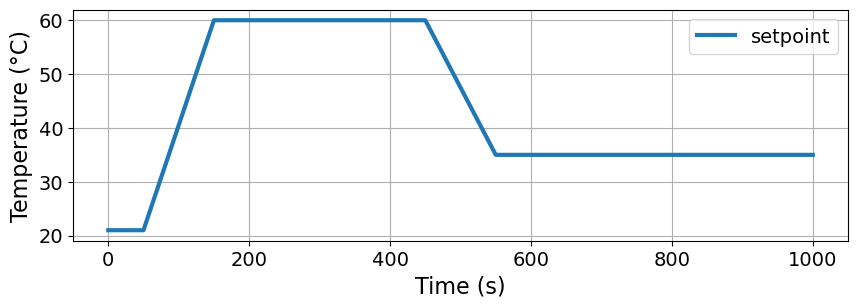

In [7]:
import numpy as np

# time grid
tf = 1000
dt = 2
n = round(tf / dt)
t_grid = np.linspace(0, 1000, n + 1)

# ambient temperature
Tamb = 21


# setpoint/reference
def r(t):
    return np.interp(t, [0, 50, 150, 450, 550], [Tamb, Tamb, 60, 60, 35])


# plot the setpoint function
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t_grid, r(t_grid), label="setpoint")
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel("Time (s)")
ax.legend()
ax.grid(True)

Now let's solve the optimal control problem to find a control policy $u(t)$ for the interval $t_0 \leq t \leq t_f$ which causes the output $T_H(t)$ to track a desired setpoint or reference tracjectory $SP(t)$.

\begin{align*}
\min_{u(t)} ~~ & \int_{t_0}^{t_f} \|~SP(t) - T_H(t)~\|^2\,dt \\
\mathrm{s.t.}~~ & C_p^H \frac{dT_H}{dt} = U_a (T_{amb} - T_H) + U_b (T_S - T_H) + \alpha P u(t) \\
 & C_p^S \frac{dT_S}{dt} = - U_b (T_S - T_H) \\
 & T_H(t_0) = T_{amb} \\
 & T_S(t_0) = T_{amb}
\end{align*}

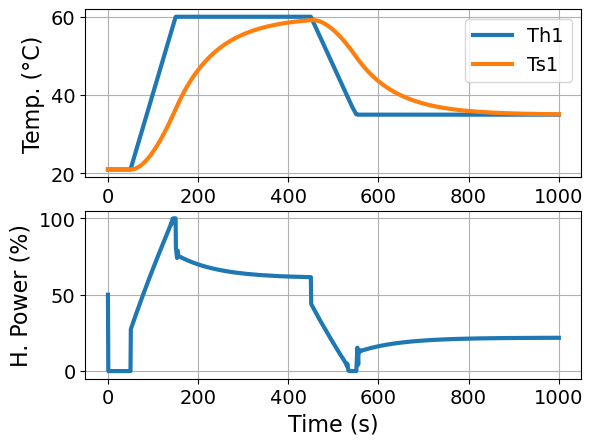

In [8]:
# Create a Pyomo model
m = pyo.ConcreteModel('TCLab Heater/Sensor')

# Define time domain
m.t = dae.ContinuousSet(bounds=(0, tf))

# Define the state variables as a function of time
m.Th1 = pyo.Var(m.t)
m.Ts1 = pyo.Var(m.t)

# Define the derivatives of the state variables
m.dTh1 = dae.DerivativeVar(m.Th1)
m.dTs1 = dae.DerivativeVar(m.Ts1)

# Define the control variable (heater power) as a function of time
m.u1 = pyo.Var(m.t, bounds=(0, 100))


# Define the integral of the squared error
@m.Integral(m.t)
def ise(m, t):
    return (r(t) - m.Th1[t]) ** 2


# Define the first differential equation
@m.Constraint(m.t)
def heater1(m, t):
    return (
        CpH * m.dTh1[t]
        == Ua * (Tamb - m.Th1[t]) + Ub * (m.Ts1[t] - m.Th1[t]) + alpha * P * m.u1[t]
    )


# Define the second differential equation
@m.Constraint(m.t)
def sensor1(m, t):
    return CpS * m.dTs1[t] == Ub * (m.Th1[t] - m.Ts1[t])


# Fix the initial conditions
m.Th1[0].fix(Tamb)
m.Ts1[0].fix(Tamb)


# Define the objective function
@m.Objective(sense=pyo.minimize)
def objective(m):
    return m.ise


# Apply a collocation method to numerically integrate the differential equations
pyo.TransformationFactory('dae.collocation').apply_to(m, nfe=200, wrt=m.t)

# Call our nonlinear optimization/equation solver, Ipopt
pyo.SolverFactory('ipopt').solve(m)

plot_results(m)

## Helper Functions

To simplify the code, we have prepared some helper functions to assemble Pyomo models and manipulate data. Please spend the next 5 minutes studying [tclab_pyomo.py](https://github.com/dowlinglab/pyomo-doe/blob/main/notebooks/tclab_pyomo.py)


## Take Away Messages

This example shows two things:
1. Pyomo is a great environment to formulate and solve optimization problems.
2. Predictive models are critical for intelligent decision making.

For the result of the workshop, we will use Pyomo to:
1. Estimate the model parameters in the TCLab model from experimental data.
2. Determine the most informative next experiment to reduce uncertainty in the model parameters.

